In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data import random_split
from callbacks import EarlyStopping
import torchvision.transforms as transforms

np.random.seed(123)
torch.manual_seed(123)

In [2]:
# データの準備
path = "D:Statistics/data/deep_leraning/"
root = os.path.join(path, "torch", "mnist")
transform = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1)])
mnist_train = datasets.MNIST(root=root, download=True, train=True, transform=transform)
mnist_test = datasets.MNIST(root=root, download=True, train=False, transform=transform)

n_samples = len(mnist_train)
n_train = int(n_samples * 0.8)
n_val = n_samples - n_train
mnist_train, mnist_val = random_split(mnist_train, {n_train, n_val})

train_dataloader = DataLoader(mnist_train, batch_size=100, shuffle=True)
val_dataloader = DataLoader(mnist_val, batch_size=100, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=100, shuffle=False)

In [3]:
# DNNを定義
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, rate):
        super().__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.a1 = nn.ReLU()
        self.d1 = nn.Dropout(rate)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.a2 = nn.ReLU()
        self.d2 = nn.Dropout(rate)
        self.l3 = nn.Linear(hidden_dim, hidden_dim)
        self.a3 = nn.ReLU()
        self.d3 = nn.Dropout(rate)
        self.l4 = nn.Linear(hidden_dim, output_dim)
        self.layers = [self.l1, self.a1, self.d1, self.l2, self.a2, self.d2, self.l3, self.a3, self.d3, self.l4]

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [21]:
# モデルの学習
# アルゴリズムの定義
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = np.unique(train_dataloader.dataset.dataset.classes).shape[0]
m = np.prod((train_dataloader.dataset.dataset.data).shape[1:])
rate = 0.5
model = DNN(m, 200, classes, rate).to(device)
criterion = nn.CrossEntropyLoss()

# optimizerを定義
optimizer_sgd = optimizers.SGD(model.parameters(), lr=0.01)   # 確率的勾配法
optimizer_momemtum = optimizers.SGD(model.parameters(), lr=0.01, momentum=0.9)   #モメンタム法
optimizer_nesterov = optimizers.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)   #N esterovモメンタム法
optimizer_adagrad = optimizers.Adagrad(model.parameters(), lr=0.01)   # Adagrad
optimizer_rms = optimizers.RMSprop(model.parameters(), lr=0.01)   # RMSproop
optimizer_adadelta = optimizers.Adadelta(model.parameters(), rho=0.95)   # Adadelta
optimizer_adam = optimizers.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))   # Adam
optimizer_amsgrad = optimizers.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), amsgrad=True)   # AMSgrad

def compute_loss(t, y):
    return criterion(y, t)

def train_step(x, t, optimizer):
    model.train()
    preds = model(x)
    loss = compute_loss(t, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds

def val_step(x, t):
    model.eval()
    preds = model(x)
    loss = criterion(preds, t)
    return loss, preds

# アルゴリズムの設定
epochs = 30
es = EarlyStopping(patience=5, verbose=1)
disp = 5

In [23]:
# 確率的勾配法でモデルを学習
# optimizerを定義
model = DNN(m, 200, classes, rate).to(device)
optimizer_sgd = optimizers.SGD(model.parameters(), lr=0.01)   # 確率的勾配法
hist_sgd = {"train_loss": [], "train_accuracy": [], "val_loss" : [], "val_accuracy": []}

# パラメータを推定
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t, optimizer_sgd)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    hist_sgd["train_loss"].append(train_loss)
    hist_sgd["train_accuracy"].append(train_acc)
    
    for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())
        
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    
    hist_sgd["val_loss"].append(val_loss)
    hist_sgd["val_accuracy"].append(val_acc)
    
    if epoch%disp==0:
        print("epoch: {}, loss: {:.3}, acc: {:.3f}, val_loss: {:.3}, val_acc: {:.3f}".format(
            epoch, train_loss, train_acc, val_loss, val_acc))

epoch: 0, loss: 2.3, acc: 0.129, val_loss: 2.28, val_acc: 0.322
epoch: 5, loss: 0.857, acc: 0.721, val_loss: 0.564, val_acc: 0.847
epoch: 10, loss: 0.511, acc: 0.848, val_loss: 0.331, val_acc: 0.904
epoch: 15, loss: 0.39, acc: 0.888, val_loss: 0.252, val_acc: 0.927
epoch: 20, loss: 0.318, acc: 0.909, val_loss: 0.207, val_acc: 0.938
epoch: 25, loss: 0.276, acc: 0.923, val_loss: 0.178, val_acc: 0.947


In [26]:
# モメンタム法でモデルを学習
# optimizerを定義
model = DNN(m, 200, classes, rate).to(device)
optimizer_momemtum = optimizers.SGD(model.parameters(), lr=0.01, momentum=0.9)   #モメンタム法
hist_momemtum = {"train_loss": [], "train_accuracy": [], "val_loss" : [], "val_accuracy": []}

# パラメータを推定
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t, optimizer_momemtum)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    hist_momemtum["train_loss"].append(train_loss)
    hist_momemtum["train_accuracy"].append(train_acc)
    
    for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())
        
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    
    hist_momemtum["val_loss"].append(val_loss)
    hist_momemtum["val_accuracy"].append(val_acc)
    
    
    if epoch%disp==0:
        print("epoch: {}, loss: {:.3}, acc: {:.3f}, val_loss: {:.3}, val_acc: {:.3f}".format(
            epoch, train_loss, train_acc, val_loss, val_acc))

epoch: 0, loss: 1.37, acc: 0.537, val_loss: 0.41, val_acc: 0.885
epoch: 5, loss: 0.218, acc: 0.938, val_loss: 0.131, val_acc: 0.960
epoch: 10, loss: 0.156, acc: 0.955, val_loss: 0.104, val_acc: 0.969
epoch: 15, loss: 0.128, acc: 0.963, val_loss: 0.0953, val_acc: 0.972
epoch: 20, loss: 0.113, acc: 0.967, val_loss: 0.0891, val_acc: 0.974
epoch: 25, loss: 0.104, acc: 0.970, val_loss: 0.089, val_acc: 0.975


In [27]:
# Adagradでモデルを学習
# optimizerを定義
model = DNN(m, 200, classes, rate).to(device)
optimizer_adagrad = optimizers.Adagrad(model.parameters(), lr=0.01)   # Adagrad
hist_adagrad = {"train_loss": [], "train_accuracy": [], "val_loss" : [], "val_accuracy": []}

# パラメータを推定
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t, optimizer_adagrad)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    hist_adagrad["train_loss"].append(train_loss)
    hist_adagrad["train_accuracy"].append(train_acc)
    
    for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())
        
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    
    hist_adagrad["val_loss"].append(val_loss)
    hist_adagrad["val_accuracy"].append(val_acc)
    
    if epoch%disp==0: 
        print("epoch: {}, loss: {:.3}, acc: {:.3f}, val_loss: {:.3}, val_acc: {:.3f}".format(
            epoch, train_loss, train_acc, val_loss, val_acc))

epoch: 0, loss: 0.517, acc: 0.840, val_loss: 0.223, val_acc: 0.935
epoch: 5, loss: 0.188, acc: 0.947, val_loss: 0.137, val_acc: 0.960
epoch: 10, loss: 0.154, acc: 0.957, val_loss: 0.116, val_acc: 0.965
epoch: 15, loss: 0.132, acc: 0.962, val_loss: 0.109, val_acc: 0.968
epoch: 20, loss: 0.12, acc: 0.965, val_loss: 0.103, val_acc: 0.970
epoch: 25, loss: 0.11, acc: 0.968, val_loss: 0.101, val_acc: 0.971


In [28]:
# AdaDeltaでモデルを学習
# optimizerを定義
model = DNN(m, 200, classes, rate).to(device)
optimizer_adadelta = optimizers.Adadelta(model.parameters(), rho=0.95)   # Adadelta
hist_adadelta = {"train_loss": [], "train_accuracy": [], "val_loss" : [], "val_accuracy": []}

# パラメータを推定
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t, optimizer_adadelta)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    hist_adadelta["train_loss"].append(train_loss)
    hist_adadelta["train_accuracy"].append(train_acc)
    
    for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())
        
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    
    hist_adadelta["val_loss"].append(val_loss)
    hist_adadelta["val_accuracy"].append(val_acc)
    
    if epoch%disp==0:
        print("epoch: {}, loss: {:.3}, acc: {:.3f}, val_loss: {:.3}, val_acc: {:.3f}".format(
            epoch, train_loss, train_acc, val_loss, val_acc))

epoch: 0, loss: 0.608, acc: 0.806, val_loss: 0.206, val_acc: 0.940
epoch: 5, loss: 0.181, acc: 0.951, val_loss: 0.116, val_acc: 0.968
epoch: 10, loss: 0.143, acc: 0.961, val_loss: 0.118, val_acc: 0.972
epoch: 15, loss: 0.126, acc: 0.967, val_loss: 0.108, val_acc: 0.974
epoch: 20, loss: 0.117, acc: 0.970, val_loss: 0.107, val_acc: 0.974
epoch: 25, loss: 0.105, acc: 0.973, val_loss: 0.107, val_acc: 0.975


In [29]:
# Adamでモデルを学習
# optimizerを定義
model = DNN(m, 200, classes, rate).to(device)
optimizer_adam = optimizers.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))   # Adam
hist_adam = {"train_loss": [], "train_accuracy": [], "val_loss" : [], "val_accuracy": []}

# パラメータを推定
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t, optimizer_adam)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    hist_adam["train_loss"].append(train_loss)
    hist_adam["train_accuracy"].append(train_acc)
    
    for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())
        
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    
    hist_adam["val_loss"].append(val_loss)
    hist_adam["val_accuracy"].append(val_acc)
    
    if epoch%disp==0:
        print("epoch: {}, loss: {:.3}, acc: {:.3f}, val_loss: {:.3}, val_acc: {:.3f}".format(
            epoch, train_loss, train_acc, val_loss, val_acc))

epoch: 0, loss: 0.603, acc: 0.809, val_loss: 0.209, val_acc: 0.937
epoch: 5, loss: 0.162, acc: 0.954, val_loss: 0.105, val_acc: 0.969
epoch: 10, loss: 0.124, acc: 0.965, val_loss: 0.096, val_acc: 0.972
epoch: 15, loss: 0.108, acc: 0.968, val_loss: 0.0902, val_acc: 0.973
epoch: 20, loss: 0.0983, acc: 0.971, val_loss: 0.0834, val_acc: 0.976
epoch: 25, loss: 0.0926, acc: 0.973, val_loss: 0.089, val_acc: 0.976


In [30]:
# AMSGradでモデルを学習
# optimizerを定義
model = DNN(m, 200, classes, rate).to(device)
optimizer_amsgrad = optimizers.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), amsgrad=True)   # AMSgrad
hist_amsgrad = {"train_loss": [], "train_accuracy": [], "val_loss" : [], "val_accuracy": []}

# パラメータを推定
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t, optimizer_amsgrad)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    hist_amsgrad["train_loss"].append(train_loss)
    hist_amsgrad["train_accuracy"].append(train_acc)
    
    for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())
        
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    
    hist_amsgrad["val_loss"].append(val_loss)
    hist_amsgrad["val_accuracy"].append(val_acc)
    
    if epoch%disp==0:
        print("epoch: {}, loss: {:.3}, acc: {:.3f}, val_loss: {:.3}, val_acc: {:.3f}".format(
            epoch, train_loss, train_acc, val_loss, val_acc))

epoch: 0, loss: 0.602, acc: 0.809, val_loss: 0.208, val_acc: 0.937
epoch: 5, loss: 0.158, acc: 0.954, val_loss: 0.109, val_acc: 0.967
epoch: 10, loss: 0.123, acc: 0.964, val_loss: 0.0885, val_acc: 0.974
epoch: 15, loss: 0.105, acc: 0.969, val_loss: 0.0871, val_acc: 0.974
epoch: 20, loss: 0.0916, acc: 0.973, val_loss: 0.0918, val_acc: 0.975
epoch: 25, loss: 0.0834, acc: 0.975, val_loss: 0.0908, val_acc: 0.976


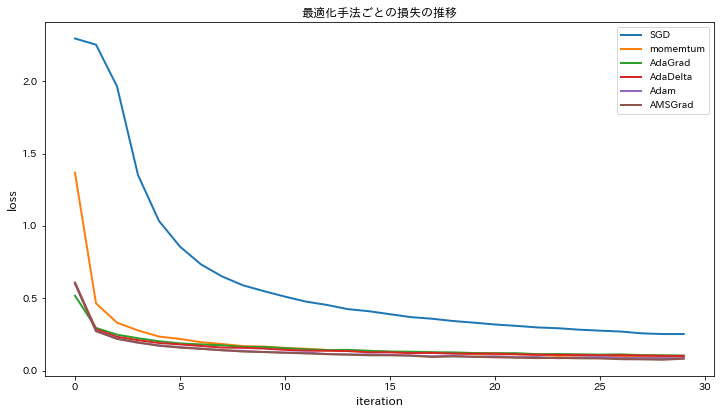

In [63]:
# 損失関数の推移を可視化
# データフレームに格納
target = "train_loss"
loss_result= pd.DataFrame({"SGD": hist_sgd[target], "momemtum": hist_momemtum[target], "AdaGrad": hist_adagrad[target],
                           "AdaDelta": hist_adadelta[target], "Adam": hist_adam[target], "AMSGrad": hist_amsgrad[target]})
k = loss_result.shape[1]

# 最適化手法ごとに可視化
fig = plt.figure(figsize=(12.0, 6.5))
for j in range(k):
    plt.plot(loss_result.iloc[:, j], label=loss_result.columns[j], linewidth=2.0)
    plt.title("最適化手法ごとの損失の推移")
    plt.xlabel("iteration", fontsize=12.0)
    plt.ylabel("loss", fontsize=12.0)
plt.legend()